## GMM: Beyond k-Means

**Unsupervised learning: distribution generation**

**Abstract:** When thinking of unsupervised learning models, k-means clustering is probably the first example to come to mind. And for good reason. It is simple to explain to your grandma (or top management if you will) and it gets the job done in most cases. However, it has clear limitations. A good alternative is Gaussian mixed models (GMM), its "brother from another mother". This notebook aims to building the intuition for the limitations of k-means and why GMM is a suitable alternative in such cases.

**Topics covered:** k-means clustering, Gaussian mixed models (GMM).

**What is k-means and what's wrong with it?** In a nutshell, k-means is a nonparametric, nonprobabilistic clustering model based on an expectation-maximization (EM) algorithm that, in its convergence, assigns each data point to its closest cluster center. It follows the following steps:

<p>&nbsp; &nbsp; 1. Guess some initial cluster centers</p>
<p>&nbsp; &nbsp; 2. Repeat until converged (i.e. until there is no more tangible improvement in the fitness function)</p>
<p>&nbsp; &nbsp; &nbsp; a) E-step: assign points to nearest center, i.e. update expectation to what cluster each point belongs to</p>
<p>&nbsp; &nbsp; &nbsp; b) M-step: set cluster centers to the mean, i.e. maximizing fitness function defining cluster centers</p>

Being nonparametric appeals to many as there is little to none hyperparameter setting and tuning. The only parameter that needs to be difined from the get-go is the number of cluster centers. The fact that it is nonprobabilistic though, means that there is no uncertainty (i.e. probability) being considered when assigning points to nearby centers. This is especially an issue when clusters overlap. This is the first issue. The second issue stems from the simple distance-from-cluster center approach k-means takes. This approach runs under the implicit assumption that the clusters are circular. There is no way, at least built-in, to account for other shapes (ellipses and so on).

Here a fabricated dataset to visualize these two shortcomings. 

**Setup.**

In [1]:
from sklearn.datasets._samples_generator import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Generate random data
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=.9, random_state=9)

In [3]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    # Fit model
    y_pred = kmeans.fit_predict(X)
    # Plot clusters
    ax = ax or plt.gca()
    ax.set_title('Clusters and their implied circular model implied by k-means')
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=y_pred, s=80, edgecolors='w')
    # Plot implied circular models
    centers = kmeans.cluster_centers_
    radii = [cdist(X[y_pred == i], [c]).max() for i, c in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, color='k', 
                                fc='gray', ls='-', lw=2, alpha=.1, zorder=1))

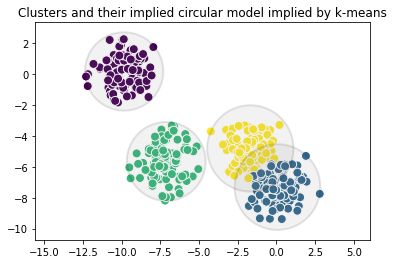

In [4]:
kmeans = KMeans(4, random_state=0)
plot_kmeans(kmeans, X)

The upper-left and lower-right clusters are a relatively easy call. The other two clusters, the two lower-right ones, show some massive overlaps. Especially with edge cases, especially if we don't know their labels, it would be very hard to decide what cluster these points belong to. And remember, with k-means we don't have a measure of probability either.

Consider also the following case where the poor performance of k-means for noncircular clusters is obvious.

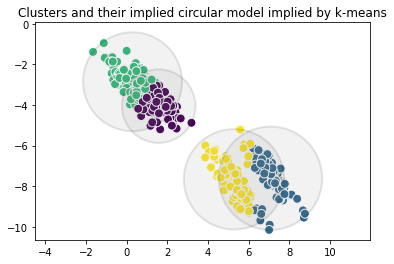

In [5]:
# Generate random data
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
plot_kmeans(kmeans, X_stretched)

**Enter GMM.** Gaussian mixed models, or simply GMM, is a generative probabilistic model that tries to describe the underlying probability distribution that produced the data that we see. So, strictly speaking, unlike k-means it is not a clustering model, but it can be used for that purpose. Like k-means, it is an E-M algorithm too. It follows the following steps:

<p>&nbsp; &nbsp; 1. Guess some initial cluster centers</p>
<p>&nbsp; &nbsp; 2. Repeat until converged (i.e. until there is no more tangible improvement in the fitness function)</p>
<p>&nbsp; &nbsp; &nbsp; a) E-step: compute weights for the membership probability to each cluster for each data point</p>
<p>&nbsp; &nbsp; &nbsp; b) M-step: making use of the weights, update the location and shape of each cluster based on all points</p>

In [6]:
def draw_ellipse(position, covariance, ax=None, **kwargs): 
    '''Draw an ellipse with given position & covariance'''
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, S, _ = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        w, h = 2 * np.sqrt(S)
    else:
        angle = 0
        w, h = 2 * np.sqrt(covariance)
    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * w, nsig * h, angle, **kwargs))

In [7]:
def plot_gmm(gmm, X, n_clusters=4, rseed=0, ax=None):
    # Fit model
    y_pred = gmm.fit_predict(X)
    # Plot clusters
    ax = ax or plt.gca()
    ax.set_title('GMM clusters')
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=y_pred, s=80, edgecolors='w')
    # Plot implied circular models
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor, color='k', 
                     fc='gray', ls='-', lw=2, zorder=1)

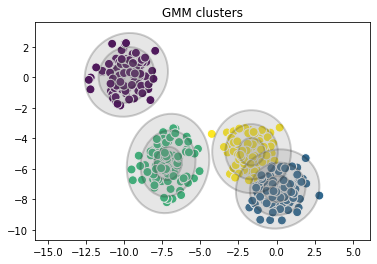

In [8]:
gmm = GaussianMixture(n_components=4, random_state=0)
plot_gmm(gmm, X)

With GMM we can find the probabilites leading to the cluster assignment for each data point. Here for the first 5 points.

In [9]:
probs = gmm.predict_proba(X)
print(probs[:5].round(1))

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


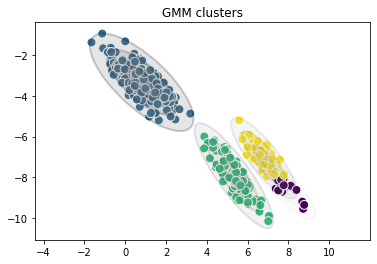

In [10]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=13)
plot_gmm(gmm, X_stretched)

GMM addresses the two main practical issues with k-means, namely the lack of flexibility in cluster shape and lack of probabilistic cluster assignment.